## Hipótese e Inferência

--------------------------------------------------------------------------------------------------------------------------------------

É mais provável que as pessoas saiam da página sem ler o conteúdo quando surge um anúncio em uma janela pop-up com um botão de fechar pequeno e inacessível?

In [2]:
from typing import Tuple 
import math

def normal_approximation_to_binomial(n: int, p: float) -> Tuple[float, float]:
    """Retorna mu e sigma correspondentes Binomial (n, p)"""
    mu = p * n
    sigma = math.sqrt(p * (1 - p) * n)
    return mu, sigma



In [3]:
# Normal cdf e inverse normal cdf

def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

def inverse_normal_cdf(p: float, mu: float = 0, sigma: float = 1, tolerance: float = 0.00001) -> float:
    """Encontre o inverso aproximado usando a pesquisa binária"""

    # se não for padrão, compute o padrão e redimensione
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)
    
    low_z = -10.0 # normal_cdf(-10) é muito próxima de 0
    hi_z = 10.0 # normal_cdf(10) é muito próxima de 1

    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2 # Considere o ponto médio
        mid_p = normal_cdf(mid_z)  # e o valor da CDF
        if mid_p < p:
            low_z = mid_z          # O ponto médio é muito baixo, procure um maior
        else: 
            hi_z = mid_z           # O ponto médio é muito alto, procure um menor

    return mid_z

Sempre que uma variável aleatória segue uma distribuição normal, é possível aplicar o normal_cdf para descobrir a probabilidade de o seu valor realizado estar contido (ou não) em um determinado intervalo

In [16]:
# O normal cdf é a probabilidade de a variável estar abaixo de um limite 
normal_probability_below = normal_cdf

# Está acima do limite se não está abaixo do limite
def normal_probability_above(lo: float, mu: float = 0, sigma: float = 1) -> float:
    """A probabilidade que um N(mu, sigma) seja maior do que lo"""
    return 1 - normal_cdf(lo, mu, sigma)

# Está entre se é menor do que hi, mas não menor do que lo
def normal_probability_between(lo: float, hi: float, mu: float = 0, sigma: float = 1) -> float:
    """A probabilidade de que um N(mu, sigma) esteja entre lo e hi"""
    return normal_cdf(hi, mu, sigma) - normal_cdf(lo, mu, sigma)

# Está fora ou não está entre
def normal_proabability_outside(lo: float, hi: float, mu: float = 0, sigma: float = 1) -> float:
    """A probabilidade de que um N(mu, sigma) não esteja entre lo e hi"""
    return 1 - normal_probability_between(lo, hi, mu, sigma)

In [5]:
def normal_upper_bound(probability: float, mu: float = 0, sigma: float = 1) -> float:
    """Retorna o z para o qual P(Z <= z) = probabilidade"""
    return inverse_normal_cdf(probability, mu, sigma)

def normal_lower_bound(probability: float, mu: float = 0, sigma: float = 1) -> float:
    """Retorna o z para o qual P(Z >= z) = probabilidade"""
    return inverse_normal_cdf(1 - probability, mu, sigma)

def normal_two_sided_bounds(probability: float, mu: float = 0, sigma: float = 1) -> Tuple[float, float]:
    """Retorna os limites simétricos (relativos à média) que contêm a probabilidade especificada"""

    tail_probability = (1 - probability) / 2
    
    # O limite superior deve estar abaixo de tail_probability
    upper_bound = normal_lower_bound(tail_probability, mu, sigma)

    # O limite inferior deve estar acima de tail_probability
    lower_bound = normal_upper_bound(tail_probability, mu, sigma)

    return lower_bound, upper_bound

Testando uma moeda para saber se ela é honesta e possui 50% de chance de cair cara e 50% de chance de cair coroa. Para isso os lançamentos devem estar distribuidos, aproximadamente, de modo normal com média 500 e desvio padão 15.8

In [6]:
mu_0, sigma_0 = normal_approximation_to_binomial(1000, 0.5)
print(mu_0, sigma_0)

500.0 15.811388300841896


#### Executando um teste A/B

In [12]:
def parametros_estimados(N: int, n: int) -> Tuple[float, float]:
    p = n / N
    sigma = math.sqrt(p * (1 - p) / N)
    return (p, sigma)

In [13]:
def a_b_test_estatistica(N_A: int, n_A: int, N_B: int, n_B: int) -> float:
    p_A, sigma_A = parametros_estimados(N_A, n_A)
    p_B, sigma_B = parametros_estimados(N_B, n_B)
    return (p_B - p_A) / math.sqrt(sigma_A**2 + sigma_B**2)

# Esse valor vai ser aproximadamente uma normal padrão

In [22]:
def two_sided_p_value(x: float, mu: float = 0, sigma: float = 1) -> float:
    """Qual é a probabilidade de observar um valor pelo menos tão
    extremo quanto x (em qualquer direção) se os valores vêm de um
    N(mu, sigma)?"""

    if x >= mu:
        return 2 * normal_probability_above(x, mu, sigma)
    else: 
        return 2 * normal_probability_below(x, mu, sigma)

Estatísticas de testes A/B em clique em anúncios.

In [23]:
# Exemplo: anúncio A teve 200 cliques em 1000 visualizações e anúncio B teve 180 cliques em 1000 visualizações
z = a_b_test_estatistica(1000, 200, 1000, 180)
print(z, two_sided_p_value(z))

-1.1403464899034472 0.254141976542236


Esse valor é tão grande que não se pode definir se há alguma diferença

In [30]:
# Anúncio 2 com apenas 150 cliques
z = a_b_test_estatistica(1000, 200, 1000, 150)
print(z, two_sided_p_value(z))

-2.948839123097944 0.003189699706216853


Há somente uma probabilidade de 0.003 de observar essa grande diferença se os anúncios forem igualmente eficazes

#### Inferência Bayesiana

In [39]:
def B(alpha: float, beta: float) -> float:
    """Uma constante normalizadora para a qual a probabilidade total é 1"""
    return math.gamma(alpha) * math.gamma(beta) / math.gamma(alpha + beta)

def beta_pdf(x: float, alpha: float, beta: float) -> float:
    if x <= 0 or x >= 1:
        return 0
    return x ** (alpha - 1) * (1 - x) ** (beta - 1) / B(alpha, beta)

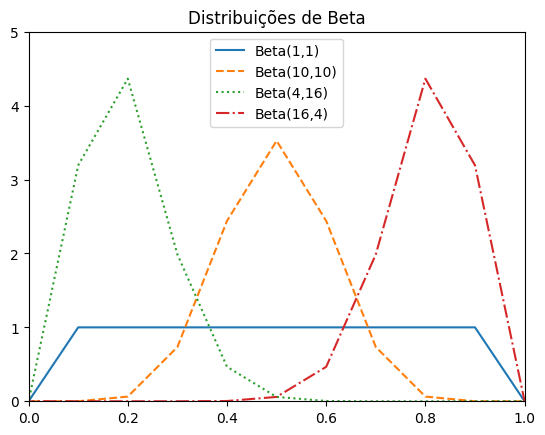

In [40]:
import matplotlib.pyplot as plt
xs = [x / 10.0 for x in range(-50, 50)]

plt.plot(xs, [beta_pdf(x, 1,1) for x in xs], '-', label='Beta(1,1)') # distribuição normal padrão
plt.plot(xs, [beta_pdf(x, 10, 10) for x in xs], '--', label='Beta(10,10)')
plt.plot(xs, [beta_pdf(x, 4, 16) for x in xs], ':', label='Beta(4,16)')
plt.plot(xs, [beta_pdf(x, 16, 4) for x in xs], '-.', label='Beta(16,4)')
plt.legend()
plt.title('Distribuições de Beta')
plt.axis([0, 1, 0, 5])
plt.show()